(150, 3)
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iterati

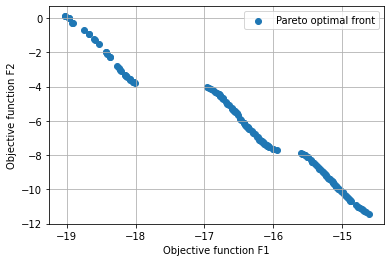

In [2]:
import random as rn
import numpy as np
import matplotlib.pyplot as plt
import math

# MINIMIZATION

# Initialize random population of parent chormosomes/solutions P
def random_population(n_var, n_sol, lb, ub):
    # n_var = numver of variables
    # n_sol = number of random solutions
    # lb = lower bound
    # ub = upper bound
    pop = np.zeros((n_sol, n_var))
    for i in range(n_sol):
        pop[i,:] = np.random.uniform(lb, ub)
    
    return pop

# On each iteration, out of 2 randomly selected parents we create 2 offsprings
# by taking fraction of genes from one parent and remaining fraction from other parent 
def crossover(pop, crossover_rate):
    offspring = np.zeros((crossover_rate, pop.shape[1]))
    for i in range(int(crossover_rate/2)):
        r1 = np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2:
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        cutting_point = np.random.randint(1, pop.shape[1])
        offspring[2*i, 0:cutting_point] = pop[r1, 0:cutting_point]
        offspring[2*i, cutting_point:] = pop[r2, cutting_point:]
        offspring[2*i+1, 0:cutting_point] = pop[r2, 0:cutting_point]
        offspring[2*i+1, cutting_point:] = pop[r1, cutting_point:]

    return offspring    # arr(crossover_size x n_var)

# On each iteration, out of 2 randomly selected parents we create 2 offsprings
# by excahging some amount of genes/coordinates between parents
def mutation(pop, mutation_rate):
    offspring = np.zeros((mutation_rate, pop.shape[1]))
    for i in range(int(mutation_rate/2)):
        r1 = np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2:
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        # We select only one gene/coordinate per chromosomes/solution for mutation here.
        # For binary solutions, number of genes for mutation can be arbitrary
        cutting_point = np.random.randint(0, pop.shape[1])
        offspring[2*i] = pop[r1]
        offspring[2*i, cutting_point] = pop[r2, cutting_point]
        offspring[2*i+1] = pop[r2]
        offspring[2*i+1, cutting_point] = pop[r1, cutting_point]

    return offspring    # arr(mutation_size x n_var)

# Create some amount of offsprings Q by adding fixed coordinate displacement to some 
# randomly selected parent's genes/coordinates
def local_search(pop, n_sol, step_size):
    # number of offspring chromosomes generated from the local search
    offspring = np.zeros((n_sol, pop.shape[1]))
    for i in range(n_sol):
        r1 = np.random.randint(0, pop.shape[0])
        chromosome = pop[r1, :]
        r2 = np.random.randint(0, pop.shape[1])
        chromosome[r2] += np.random.uniform(-step_size, step_size)
        if chromosome[r2] < lb[r2]:
            chromosome[r2] = lb[r2]
        if chromosome[r2] > ub[r2]:
            chromosome[r2] = ub[r2]

        offspring[i,:] = chromosome
    return offspring    # arr(loc_search_size x n_var)

# Calculate fitness (obj function) values for each chormosome/solution
# Kursawe function - https://en.wikipedia.org/wiki/Test_functions_for_optimization
def evaluation(pop):
    fitness_values = np.zeros((pop.shape[0], 2)) # 2 values for each choromosome/solution
    for i,x in enumerate(pop):
        obj1 = 0
        for j in range(2):
            obj1 += - 10*math.exp(-0.2*math.sqrt((x[j])**2 + (x[j+1])**2))

        obj2 = 0
        for j in range(3):
            obj2 += (abs(x[j]))**0.8 + 5*math.sin((x[j])**3)
 
        fitness_values[i,0] = obj1
        fitness_values[i,1] = obj2

    return fitness_values   # arr(pop_size x 2)

# Estimate how tightly clumped fitness values are on Pareto front. 
def crowding_calculation(fitness_values):
    pop_size = len(fitness_values[:, 0])
    fitness_value_number = len(fitness_values[0, :])                    # == n of objective functions
    matrix_for_crowding = np.zeros((pop_size, fitness_value_number))    # arr(pop_size x 2) 
    normalized_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0)  # arr.ptp(0) array of max elem in each col
    
    for i in range(fitness_value_number):
        crowding_results = np.zeros(pop_size)
        crowding_results[0] = 1 # extreme point has the max crowding distance
        crowding_results[pop_size - 1] = 1 # extreme point has the max crowding distance
        sorted_normalized_fitness_values = np.sort(normalized_fitness_values[:,i])
        sorted_normalized_values_index = np.argsort(normalized_fitness_values[:,i])
        # crowding distance calculation. Say for fitness1[i], crowding = fitness1[i+1] - fitness1[i-1]
        crowding_results[1:pop_size - 1] = (sorted_normalized_fitness_values[2:pop_size] - sorted_normalized_fitness_values[0:pop_size - 2])
        re_sorting = np.argsort(sorted_normalized_values_index)
        matrix_for_crowding[:, i] = crowding_results[re_sorting]
    
    crowding_distance = np.sum(matrix_for_crowding, axis=1) # on fitness1 - fitness2 plot, each point on pareto front has crowding distance number

    return crowding_distance    # arr(pop_size,)

# Crowding distance is used to maintain diversity of solutions on Pareto front. 
# Remove some amount of solutions that are clumped together to much
def remove_using_crowding(fitness_values, number_solutions_needed):
    pop_index = np.arange(fitness_values.shape[0])
    crowding_distance = crowding_calculation(fitness_values)
    selected_pop_index = np.zeros(number_solutions_needed)
    selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))    # arr(num_sol_needed x 2)
    for i in range(number_solutions_needed):
        pop_size = pop_index.shape[0]
        solution_1 = rn.randint(0, pop_size - 1)
        solution_2 = rn.randint(0, pop_size - 1)
        if crowding_distance[solution_1] >= crowding_distance[solution_2]:
            # solution 1 is better than solution 2
            selected_pop_index[i] = pop_index[solution_1]
            selected_fitness_values[i, :] = fitness_values[solution_1, :]
            pop_index = np.delete(pop_index, (solution_1), axis=0)
            fitness_values = np.delete(fitness_values, (solution_1), axis=0)
            crowding_distance = np.delete(crowding_distance, (solution_1), axis=0)
        else:
            # solution 2 is better than solution 1
            selected_pop_index[i] = pop_index[solution_2]
            selected_fitness_values[i, :] = fitness_values[solution_2, :]
            pop_index = np.delete(pop_index, (solution_2), axis=0)
            fitness_values = np.delete(fitness_values, (solution_2), axis=0)
            crowding_distance = np.delete(crowding_distance, (solution_2), axis=0)
    
    selected_pop_index = np.asarray(selected_pop_index, dtype=int)

    return selected_pop_index   # arr(n_sol_needed,)

# find indices of solutions that dominate others
def pareto_front_finding(fitness_values, pop_index):
    pop_size = fitness_values.shape[0]
    pareto_front = np.ones(pop_size, dtype=bool)    # all True initially
    for i in range(pop_size):
        for j in range(pop_size):
            if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                pareto_front[i] = 0 # i is not in pareto front becouse j dominates i
                break

    return pop_index[pareto_front]  # arr(len_pareto_front,)

# repeat Pareto front selection to build a population within defined size limits
def selection(pop, fitness_values, pop_size):
    
    pop_index_0 = np.arange(pop.shape[0])   # unselected pop ids
    pop_index = np.arange(pop.shape[0])     # all pop ids. len = len(pop_size)
    pareto_front_index = []
    
    while len(pareto_front_index) < pop_size:   # pop_size = initial_pop_size
        new_pareto_front = pareto_front_finding(fitness_values[pop_index_0, :], pop_index_0)
        total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

        # check the size of pareto_front, if larger than pop_size then remove some
        if total_pareto_size > pop_size:
            number_solutions_needed = pop_size - len(pareto_front_index)
            selected_solutions = remove_using_crowding(fitness_values[new_pareto_front], number_solutions_needed)
            new_pareto_front = new_pareto_front[selected_solutions]
        
        pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
        remaining_index = set(pop_index) - set(pareto_front_index)
        pop_index_0 = np.array(list(remaining_index))
        
    selected_pop = pop[pareto_front_index.astype(int)]

    return selected_pop     # arr(pop_size x n_var)

# Parameters
n_var = 3                   # chromosome has 3 coordinates/genes
lb = [-5, -5, -5]
ub = [5, 5, 5]
pop_size = 150              # initial number of chormosomes
rate_crossover = 20         # number of chromosomes that we apply crossower to
rate_mutation = 20          # number of chromosomes that we apply mutation to
rate_local_search = 10      # number of chromosomes that we apply local_search to
step_size = 0.1             # coordinate displacement during local_search
maximum_generation = 150    # number of iterations
pop = random_population(n_var, pop_size, lb, ub)    # initial parents population P
print(pop.shape)


# NSGA-II main loop
for i in range(maximum_generation):
    offspring_from_crossover = crossover(pop, rate_crossover)
    offspring_from_mutation = mutation(pop, rate_mutation)
    offspring_from_local_search = local_search(pop, rate_local_search, step_size)
    
    # we append childrens Q (cross-overs, mutations, local search) to paraents P
    # having parents in the mix, i.e. allowing for parents to progress to next iteration - Elitism
    pop = np.append(pop, offspring_from_crossover, axis=0)
    pop = np.append(pop, offspring_from_mutation, axis=0)
    pop = np.append(pop, offspring_from_local_search, axis=0)
    # print(pop.shape)
    fitness_values = evaluation(pop)
    pop = selection(pop, fitness_values, pop_size)  # we arbitrary set desired pereto front size = pop_size
    print('iteration:', i)

# Pareto front visualization
fitness_values = evaluation(pop)
index = np.arange(pop.shape[0]).astype(int)
pareto_front_index = pareto_front_finding(fitness_values, index)
pop = pop[pareto_front_index, :]
print("_________________")
print("Optimal solutions:")
print("       x1               x2                 x3")
print(pop) # show optimal solutions
fitness_values = fitness_values[pareto_front_index]
print("______________")
print("Fitness values:")
print("  objective 1    objective 2")
print(fitness_values)
plt.scatter(fitness_values[:, 0],fitness_values[:, 1], label='Pareto optimal front')
plt.legend(loc='best')
plt.xlabel('Objective function F1')
plt.ylabel('Objective function F2')
plt.grid(visible=1)
plt.show()

# name: ZDT1
# n_var: 30
# n_obj: 2
# n_ieq_constr: 0
# n_eq_constr: 0



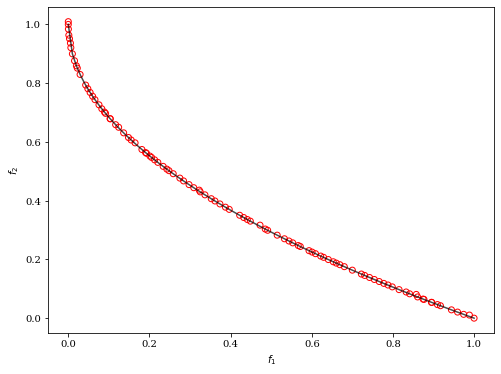

In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1")
print(problem)

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()